In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from seminartools.models.utils import get_mse_by_country
from seminartools.data import read_merged
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel
from seminartools.models.mucsvss_model import MUCSVSSModel
from seminartools.models.pca_var_model import PCAVARModel


muc_model = MUCSVSSModel(num_particles=100008, stochastic_seasonality=True)
muc_model.load_from_disk("../../models/mucsvss_model_100008_deterministic_all.pkl")
muc_model

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [3]:
df = read_merged().reset_index()


In [4]:
# expanding window crossval
from seminartools.time_series_split import ExpandingWindowSplit

tss = ExpandingWindowSplit(start_date = "2000-01-01")
tss

# Try multistep ahead UCSVSS model

In [46]:
UCSV = UCSVSSModel(num_particles = 10000, stochastic_seasonality=False)
UCSV.full_fit(df)
UCSV

  0%|          | 0/20 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
100%|██████████| 20/20 [05:43<00:00, 17.16s/it]


In [47]:
from seminartools.models.utils import h_period_ahead_forecast

forecast = h_period_ahead_forecast(UCSV, df, "2010-01-01", h=1)
forecast

inflation        country       date
0      0.000057          Japan 2010-01-01
1      0.004695         Canada 2010-01-01
2      0.006775  United States 2010-01-01
3      0.006854      Australia 2010-01-01
4      0.006583    New Zealand 2010-01-01
...         ...            ...        ...
1055   0.006808         Norway 2023-01-01
1056   0.029823        Belgium 2023-01-01
1057   0.006975          Korea 2023-01-01
1058   0.012707   South Africa 2023-01-01
1059   0.028561        Türkiye 2021-01-01

[1060 rows x 3 columns]

In [59]:
from seminartools.models.utils import make_oos_predictions

forecast = make_oos_predictions(lambda: UCSVSSModel(num_particles = 1000, stochastic_seasonality=False), df,tss,h=4)
forecast

Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x12c648080>)


100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


Fitted!


inflation        country       date
0      0.001373          Japan 2000-01-01
1      0.002628         Canada 2000-01-01
2      0.003859  United States 2000-01-01
3      0.000464      Australia 2000-01-01
4     -0.002536    New Zealand 2000-01-01
...         ...            ...        ...
1821   0.006270         Norway 2023-01-01
1822   0.026322        Belgium 2023-01-01
1823   0.004649          Korea 2023-01-01
1824   0.012796   South Africa 2023-01-01
1825   0.030035        Türkiye 2021-10-01

[1826 rows x 3 columns]

/Users/matthy/Desktop/IBEOR/third_year/seminar_forecasting/Bayesian/seminar-1/seminartools/models/armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast += exog_coefs[j] * exogData[i-1]
/Users/matthy/Desktop/IBEOR/third_year/seminar_forecasting/Bayesian/seminar-1/seminartools/models/armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast += exog_coefs[j] * exogData[i-1]
/Users/matthy/Desktop/IBEOR/third_year/seminar_forecasting/Bayesian/seminar-1/seminartools/models/armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

date        country  inflation
0    1999-04-01          Japan   0.002142
1    1999-04-01         Canada  -0.001565
2    1999-04-01  United States   0.004315
3    1999-04-01      Australia   0.002457
4    1999-04-01    New Zealand  -0.000308
...         ...            ...        ...
1516 2022-04-01         Norway   0.004182
1517 2022-04-01        Belgium   0.015887
1518 2022-04-01          Korea   0.009941
1519 2022-04-01   South Africa   0.010410
1520 2021-01-01        Türkiye   0.025810

[1521 rows x 3 columns]

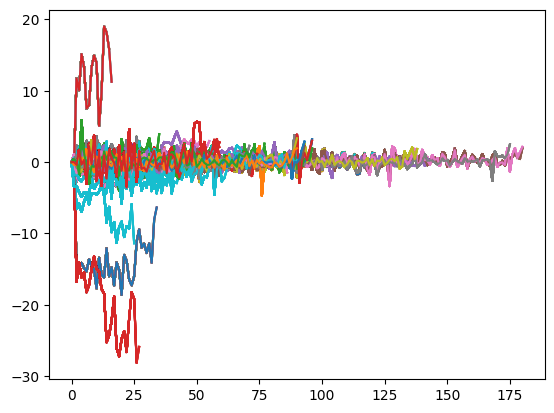

In [15]:
from seminartools.models.utils import make_oos_predictions

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]
forecast = make_oos_predictions(lambda: ARMAXModel(max_p=2, max_q=0, exogenous_columns=exog_columns), df,tss,h=4)
forecast

In [24]:
f = forecast['inflation']
f


0       0.022951
1       0.023904
2       0.017231
3       0.027244
4       0.023346
          ...   
5652         NaN
5653         NaN
5654         NaN
5655         NaN
5656         NaN
Name: inflation, Length: 5657, dtype: float64

# 1. Get stats for four steps ahead forecast

In [16]:
from seminartools.models.utils import get_stats
exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats = get_stats(
    [
     ("4qa", lambda: FourQuarterAverageModel()),
     # ("pca_var", lambda: PCAVARModel()),
        ("ar", lambda: ARMAXModel(max_p=2, max_q=0)),
       (
          "arx",
            lambda: ARMAXModel(max_p=2, max_q=0, exogenous_columns=exog_columns),
       ),
      ("arma", lambda: ARMAXModel(max_p=2, max_q=2)),
        (
            "armax",
           lambda: ARMAXModel(max_p=2, max_q=2, exogenous_columns=exog_columns),
       ),
      (
             "uc_sv",
           lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=False),
        ),
      (
           "uc_sv_ss",
            lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=True),
       ),
        # ("random_effects", lambda: RandomEffectsModel()),
       #  (
       #    "random_effects_x",
       #      lambda: RandomEffectsModel(exogenous_columns=exog_columns),
       #  ),
       #  ("distance", lambda: DistanceModel()),
       #  ("distance_x", lambda: DistanceModel(exogenous_columns=exog_columns)),
      ("mucsvss", lambda: muc_model),
       
    ],
    df,
    tss,
    h = 4,
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)
stats

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/si

Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x148e5ecf0>)


100%|██████████| 20/20 [07:45<00:00, 23.28s/it]


Fitted!


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x1498a4890>)


100%|██████████| 20/20 [04:12<00:00, 12.62s/it]


Fitted!


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Fitting model on the full dataset... (model=<seminartools.models.mucsvss_model.MUCSVSSModel object at 0x128414440>)
Fitted!


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


mse       mae          r2  mz_intercept  mz_slope     mz_r2  \
4qa       0.000050  0.005075    0.252393      0.001491  0.803596  0.270771   
ar        0.000052  0.005124    0.250935      0.000373  0.867354  0.260003   
uc_sv     0.000059  0.005380    0.167096      0.001680  0.814457  0.181817   
uc_sv_ss  0.000084  0.006688   -0.184661      0.004666  0.303260  0.041316   
arma      0.000157  0.006549   -1.267341      0.004324  0.206781  0.090734   
mucsvss   0.000263  0.011498   -2.723450      0.005987  0.059241  0.010842   
arx       0.000742  0.011178   -9.745889      0.005246  0.065576  0.047840   
armax     0.020293  0.045729 -292.904351      0.005781  0.006307  0.011780   

          mz_wald_test_statistic                 p-value  
4qa                    21.181843   8.219537822627104e-10  
ar                      8.810433  0.00015737330149855573  
uc_sv                  15.770578  1.6285918353894583e-07  
uc_sv_ss              206.604931  2.7122906157164995e-81  
arma                 1073.894724   4.81037351125019e-286  
mucsvss              2422.874618                     0.0  
arx                  7395.487435                     0.0  
armax              213117.128021                     0.0

In [17]:
# format r2 column to 2 
format_stats = stats.copy()
format_stats['p-value'] =format_stats['p-value'].astype(float)
round_cols = ["r2", "mz_intercept", "mz_slope", "mz_r2", "mz_wald_test_statistic", "p-value"]
for col in round_cols:
    format_stats[col] = format_stats[col].apply(lambda x: round(x, 3))

format_stats['mz_wald_test_statistic'] = format_stats['mz_wald_test_statistic'].astype(str) + '(' + format_stats['p-value'].astype(str) + ')'
format_stats.drop(columns = ['p-value'], inplace = True)

# get relative to UCSV
format_stats.loc[:,["mse","mae"]] = format_stats.loc[:,["mse","mae"]].div(format_stats.loc["uc_sv",["mse","mae"]])
format_stats

mse       mae       r2  mz_intercept  mz_slope  mz_r2  \
4qa         0.856195   0.94339    0.252         0.001     0.804  0.271   
ar          0.880713  0.952355    0.251         0.000     0.867  0.260   
uc_sv            1.0       1.0    0.167         0.002     0.814  0.182   
uc_sv_ss    1.422326  1.243172   -0.185         0.005     0.303  0.041   
arma        2.665823  1.217343   -1.267         0.004     0.207  0.091   
mucsvss     4.470443  2.137245   -2.723         0.006     0.059  0.011   
arx        12.634467  2.077775   -9.746         0.005     0.066  0.048   
armax     345.557713  8.499874 -292.904         0.006     0.006  0.012   

         mz_wald_test_statistic  
4qa                 21.182(0.0)  
ar                    8.81(0.0)  
uc_sv               15.771(0.0)  
uc_sv_ss           206.605(0.0)  
arma              1073.895(0.0)  
mucsvss           2422.875(0.0)  
arx               7395.487(0.0)  
armax           213117.128(0.0)

In [ ]:
# generate latex code for the stats table
print(
    # replace _ by \_ in columns and index
    format_stats.pipe(lambda df: df.rename(columns=lambda x: x.replace("_", "\\_")))
    .pipe(lambda df: df.rename(index=lambda x: x.replace("_", "\\_")))
    .to_latex(
        index=True,
        caption="MSPE, MAE, $R^2$, and Mincer-Zarnowitz statistics, out-of-sample, 2000-2023",
        label="tab:model_eval",
        float_format="%.4f",
    )
)